# Tugas Time Series Analisa Kualitas Udara
## Mengumpulkan data dan dijadikan CSV

Kita ambil data dari openeo, dengan fokus di area Bangkalan berdasarkan koordinat rata-rata hasil poligon yang telah di ambil dengan output "no2_bangkalan.nc"

In [7]:
import openeo
from shapely.geometry import shape

# Koneksi & autentikasi ke Copernicus Data Space Ecosystem
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# Definisi area Bangkalan (AOI)
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [112.73853929664097, -7.023628073721952],
            [112.73853929664097, -7.05158377585353],
            [112.7680283135615, -7.05158377585353],
            [112.7680283135615, -7.023628073721952],
            [112.73853929664097, -7.023628073721952],
        ]
    ],
}

# Memuat koleksi data Sentinel-5P (NO2) dari Copernicus
prob = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2025-09-24", "2025-10-24"],   # rentang waktu pengambilan data
    spatial_extent={
        "west": 112.73853929664097,
        "south": -7.05158377585353,
        "east": 112.7680283135615,
        "north": -7.023628073721952
    },
    bands=["NO2"],   # variabel polutan yang diambil
)

# Definisikan area sebagai FeatureCollection (untuk agregasi spasial)
feature = {"type": "Feature", "geometry": aoi, "properties": {"id": 1}}
fc = {"type": "FeatureCollection", "features": [feature]}

# Agregasi data secara temporal & spasial
prob = prob.aggregate_temporal_period(reducer="mean", period="day")   # rata-rata harian
prob = prob.aggregate_spatial(reducer="mean", geometries=fc)          # rata-rata per area

# Eksekusi batch job dan unduh hasil ke file .nc
job = prob.execute_batch(
    title="NO2 Bangkalan Sep-Okt 2025",
    outputfile="no2_bangkalan.nc"
)

print("Job telah di submit. File output akan tersimpan sebagai 'no2_bangkalan.nc'")


Authenticated using refresh token.
0:00:00 Job 'j-2510241407484c1691f27c835abc1235': send 'start'
0:00:14 Job 'j-2510241407484c1691f27c835abc1235': created (progress 0%)
0:00:20 Job 'j-2510241407484c1691f27c835abc1235': created (progress 0%)
0:00:26 Job 'j-2510241407484c1691f27c835abc1235': running (progress N/A)
0:00:34 Job 'j-2510241407484c1691f27c835abc1235': running (progress N/A)
0:00:45 Job 'j-2510241407484c1691f27c835abc1235': running (progress N/A)
0:00:58 Job 'j-2510241407484c1691f27c835abc1235': running (progress N/A)
0:01:13 Job 'j-2510241407484c1691f27c835abc1235': running (progress N/A)
0:01:33 Job 'j-2510241407484c1691f27c835abc1235': running (progress N/A)
0:01:58 Job 'j-2510241407484c1691f27c835abc1235': running (progress N/A)
0:02:29 Job 'j-2510241407484c1691f27c835abc1235': finished (progress 100%)
Job telah di submit. File output akan tersimpan sebagai 'no2_bangkalan.nc'


Output "no2_bangkalan.nc" akan di convert ke file format .csv

In [8]:
import xarray as xr

# open dataset NetCDF
ds = xr.open_dataset("no2_bangkalan.nc")

# lihat isi untuk menyesuaikan transformasi
print(ds)

df = ds.to_dataframe().reset_index()

# Ambil kolom waktu dan NO2
df = df[['t', 'NO2']]

# Simpan ke CSV
df.to_csv("NO2.csv", index=False)

<xarray.Dataset> Size: 200B
Dimensions:        (feature: 1, t: 11)
Coordinates:
  * t              (t) datetime64[ns] 88B 2025-09-24 2025-09-26 ... 2025-10-19
    lat            (feature) float64 8B ...
    lon            (feature) float64 8B ...
    feature_names  (feature) int64 8B ...
Dimensions without coordinates: feature
Data variables:
    NO2            (feature, t) float64 88B ...
Attributes:
    Conventions:  CF-1.8
    source:       Aggregated timeseries generated by openEO GeoPySpark backend.


## Pre-processing

Penanganan missing values menggunakan interpolasi

In [9]:
import pandas as pd

df = pd.read_csv("NO2.csv")
print("Jumlah baris:", len(df))
print(df['t'])

Jumlah baris: 11
0     2025-09-24
1     2025-09-26
2     2025-09-28
3     2025-10-02
4     2025-10-03
5     2025-10-04
6     2025-10-07
7     2025-10-08
8     2025-10-09
9     2025-10-10
10    2025-10-19
Name: t, dtype: object


Terlihat hasil data yang kita ambil berjumah 13 baris atau 13 hari dari 1 bulan, ini tanda nya satelit di sentinel_5p tidak dapat membaca data pada hari tersbut dikarenakan sensor tersbut tidak selalu melewati bangkalan setiap hari dengan awan yang bersih atau di bawah ambang batas, maka dari itu kita perlu menangani nya agar menjadi data 1 bulan penuh dengan menggunakan interpolasi

In [10]:
import pandas as pd

# Baca data asli
df = pd.read_csv("NO2.csv")
df['t'] = pd.to_datetime(df['t'])
df = df.set_index('t')

# Buat rentang tanggal penuh (harian)
full_range = pd.date_range(start='2025-09-24', end='2025-10-24', freq='D')

# Reindex ke tanggal lengkap
df = df.reindex(full_range)

# Ganti nama kolom index ke 't'
df.index.name = 't'

# Interpolasi nilai yang hilang
df['NO2'] = df['NO2'].interpolate(method='time')

print("Jumlah data setelah diisi:", len(df))
df.head(10)

Jumlah data setelah diisi: 31


,NO2
t,
2025-09-24,0.000040
2025-09-25,0.000025
2025-09-26,0.000010
2025-09-27,0.000016
2025-09-28,0.000022
2025-09-29,0.000017
2025-09-30,0.000013
2025-10-01,0.000008
2025-10-02,0.000004


In [11]:
df.to_csv("NO2_full.csv")
print("Data lengkap disimpan ke NO2_full.csv")

Data lengkap disimpan ke NO2_full.csv


## Membentuk Data Supervised

Pada tahap ini akan di bentuk data supervised supaya bisa di proses di knn nanti, dimana nanti fitur fitur nya adalah NO2 yang sebelumnya dan tagetnya adalah NO2 saat ini, artinya kita akan memprediksi NO2 saat ini berdasarkan NO2 sebelumnya

In [13]:
import pandas as pd

# Baca data hasil interpolasi (tanpa missing values)
df = pd.read_csv("NO2_full.csv")
df['t'] = pd.to_datetime(df['t'])

# Tentukan jumlah lag (3 hari sebelumnya)
lag = 3  

# Bentuk kolom lag secara otomatis
for i in range(1, lag + 1):
    df[f'NO2_lag_{i}'] = df['NO2'].shift(i)

# Hapus baris awal yang ada NaN akibat lag
df_supervised = df.dropna().reset_index(drop=True)

# Simpan hasilnya ke CSV
df_supervised.to_csv("NO2_supervised.csv", index=False)

print("Data supervised berhasil dibuat!")
print(df_supervised.head())


Data supervised berhasil dibuat!
           t       NO2  NO2_lag_1  NO2_lag_2  NO2_lag_3
0 2025-09-27  0.000016   0.000010   0.000025   0.000040
1 2025-09-28  0.000022   0.000016   0.000010   0.000025
2 2025-09-29  0.000017   0.000022   0.000016   0.000010
3 2025-09-30  0.000013   0.000017   0.000022   0.000016
4 2025-10-01  0.000008   0.000013   0.000017   0.000022


## Normalsasi Data

Pada tahap ini akan di lakukan normalisasi menggunakan zscore sklearn

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Baca data supervised
df = pd.read_csv("NO2_supervised.csv")

# Pisahkan kolom waktu
time_col = df['t']
data_features = df.drop(columns=['t'])

# Lakukan normalisasi dengan Z-Score
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_features)

# Bentuk kembali jadi DataFrame
df_scaled = pd.DataFrame(data_scaled, columns=data_features.columns)
df_scaled.insert(0, 't', time_col)

# Simpan hasil normalisasi
df_scaled.to_csv("NO2_normalized_zscore.csv", index=False)

print("Normalisasi Z-Score telah disimpan 'NO2_normalized_zscore.csv'")
print("\nContoh hasil normalisasi:")
print(df_scaled.head())


Normalisasi Z-Score telah disimpan 'NO2_normalized_zscore.csv'

Contoh hasil normalisasi:
            t       NO2  NO2_lag_1  NO2_lag_2  NO2_lag_3
0  2025-09-27 -1.344626  -1.691954  -0.464724   0.706173
1  2025-09-28 -0.835474  -1.210527  -1.667498  -0.485462
2  2025-09-29 -1.219271  -0.729100  -1.187999  -1.677097
3  2025-09-30 -1.603069  -1.091998  -0.708499  -1.202038
4  2025-10-01 -1.986866  -1.454896  -1.069945  -0.726980


## Model KNN Regression

Pada tahap ini akan dilakukan tahap pemodelan menggunakan metode KNN Regression

✅ Model KNN Regression selesai dilatih (k=5)
Mean Squared Error (MSE): 0.037252
R² Score: 0.0000


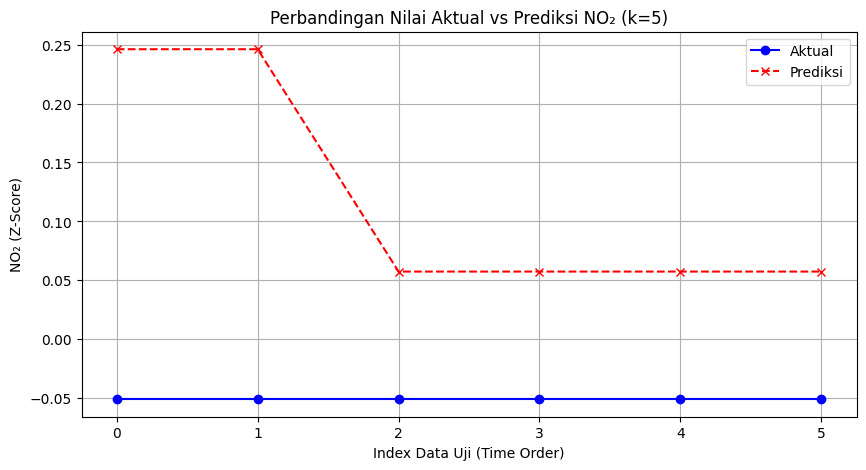

In [10]:
# === 1. Import library ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === 2. Baca data yang sudah dinormalisasi (Z-Score) ===
df = pd.read_csv("NO2_normalized_zscore.csv")

# === 3. Pisahkan fitur dan target ===
# Target kita: nilai NO2 saat ini
# Fitur: NO2_lag_1, NO2_lag_2, dst
X = df.drop(columns=['t', 'NO2'])
y = df['NO2']

# === 4. Split data menjadi train dan test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # tidak diacak karena data time series
)

# === 5. Buat dan latih model KNN Regression ===
k = 5  # kamu bisa ubah (misal 3, 7, 9)
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)

# === 6. Prediksi data test ===
y_pred = knn.predict(X_test)

# === 7. Evaluasi model ===
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Model KNN Regression selesai dilatih (k={k})")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"R² Score: {r2:.4f}")

# === 8. Visualisasi hasil prediksi vs aktual ===
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test)), y_test, 'b-', marker='o', label='Aktual')
plt.plot(range(len(y_pred)), y_pred, 'r--', marker='x', label='Prediksi')
plt.title(f'Perbandingan Nilai Aktual vs Prediksi NO₂ (k={k})')
plt.xlabel('Index Data Uji (Time Order)')
plt.ylabel('NO₂ (Z-Score)')
plt.legend()
plt.grid(True)
plt.show()


### Uji Coba Beberapa Jumlah Lag

Hasil Evaluasi Tiap Lag:
   Lag  K       MSE            R²
0    1  5  0.005931 -4.927635e+32
1    3  5  0.037252  0.000000e+00
2    5  5  0.293447  0.000000e+00
3    7  5  0.473448  0.000000e+00


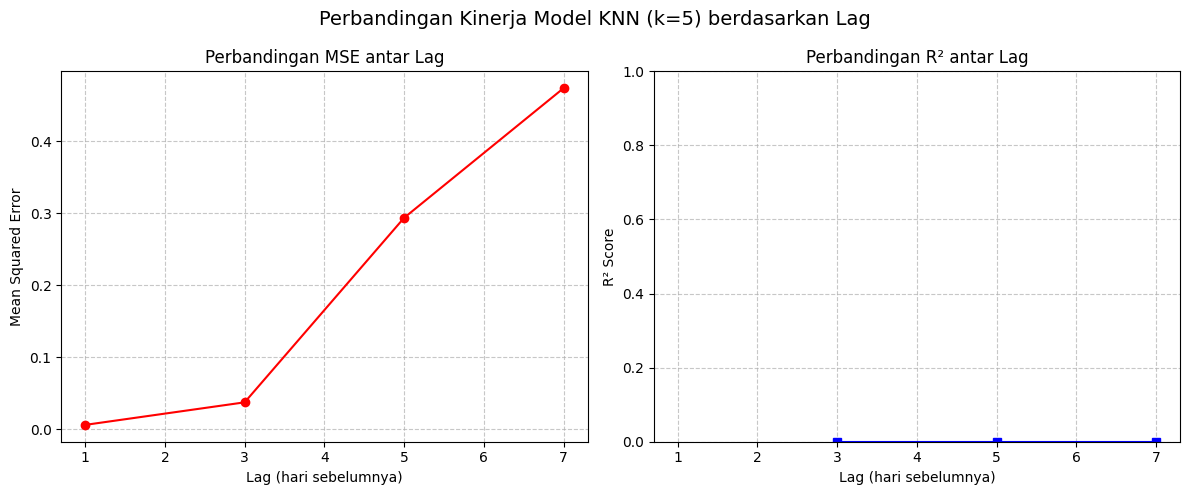

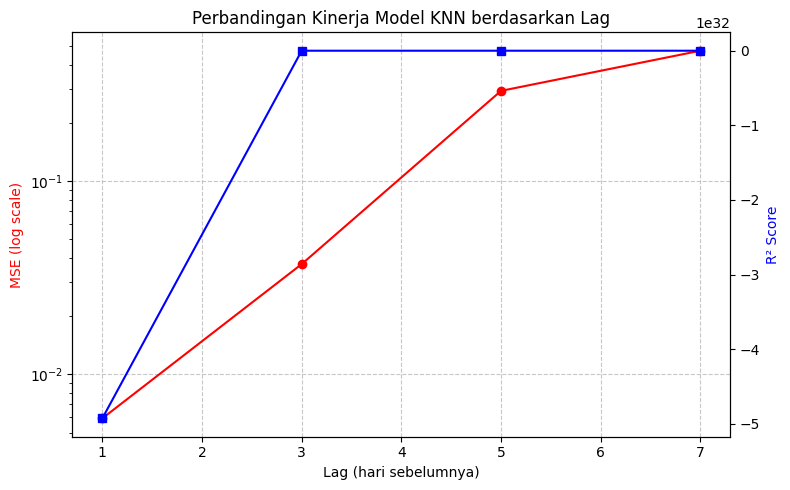

In [14]:
# === 1. Import library ===
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# === 2. Baca data dasar (hasil interpolasi penuh, belum supervised) ===
df_raw = pd.read_csv("NO2_full.csv")
df_raw['t'] = pd.to_datetime(df_raw['t'])

# === 3. Fungsi bantu untuk membentuk data supervised berdasarkan lag ===
def make_supervised(data, lag):
    df = data.copy()
    for i in range(1, lag + 1):
        df[f'NO2_lag_{i}'] = df['NO2'].shift(i)
    df = df.dropna().reset_index(drop=True)
    return df

# === 4. List lag yang akan diuji ===
lag_list = [1, 3, 5, 7]

# === 5. Parameter model ===
k = 5  # jumlah tetangga pada KNN
results = []

# === 6. Loop percobaan tiap lag ===
for lag in lag_list:
    df_supervised = make_supervised(df_raw, lag)

    # Normalisasi (Z-Score)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_supervised.drop(columns=['t']))
    df_scaled = pd.DataFrame(scaled_features, columns=df_supervised.columns.drop('t'))
    df_scaled.insert(0, 't', df_supervised['t'])
    
    # Pisahkan fitur dan target
    X = df_scaled.drop(columns=['t', 'NO2'])
    y = df_scaled['NO2']
    
    # Split train-test (time order)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Buat model dan training
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    
    # Prediksi dan evaluasi
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({'Lag': lag, 'K': k, 'MSE': mse, 'R²': r2})

# === 7. Hasil evaluasi ===
results_df = pd.DataFrame(results)
print("Hasil Evaluasi Tiap Lag:")
print(results_df)

# === 8A. Visualisasi Terpisah ===
plt.figure(figsize=(12,5))

# Grafik MSE
plt.subplot(1, 2, 1)
plt.plot(results_df['Lag'], results_df['MSE'], 'o-', color='red')
plt.title('Perbandingan MSE antar Lag')
plt.xlabel('Lag (hari sebelumnya)')
plt.ylabel('Mean Squared Error')
plt.grid(True, linestyle='--', alpha=0.7)

# Grafik R²
plt.subplot(1, 2, 2)
plt.plot(results_df['Lag'], results_df['R²'], 's-', color='blue')
plt.title('Perbandingan R² antar Lag')
plt.xlabel('Lag (hari sebelumnya)')
plt.ylabel('R² Score')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)

plt.suptitle(f'Perbandingan Kinerja Model KNN (k={k}) berdasarkan Lag', fontsize=14)
plt.tight_layout()
plt.show()

# === 8B. Visualisasi Alternatif (1 grafik log-scale) ===
fig, ax1 = plt.subplots(figsize=(8,5))
ax2 = ax1.twinx()

ax1.plot(results_df['Lag'], results_df['MSE'], 'r-o', label='MSE (log scale)')
ax2.plot(results_df['Lag'], results_df['R²'], 'b-s', label='R² Score')

ax1.set_yscale('log')
ax1.set_xlabel('Lag (hari sebelumnya)')
ax1.set_ylabel('MSE (log scale)', color='red')
ax2.set_ylabel('R² Score', color='blue')
ax1.grid(True, linestyle='--', alpha=0.7)
plt.title("Perbandingan Kinerja Model KNN berdasarkan Lag")

fig.tight_layout()
plt.show()